In [ ]:
!pip install pandas geopandas osmnx contextily rasterio scikit-image folium

In [ ]:
!pip install osmnx --upgrade

In [ ]:
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.mask import mask
import numpy as np
from tqdm.auto import tqdm # Для прогресс-бара

# --- Шаг 1: Загрузка всех необходимых данных ---
print("--- Загрузка данных ---")
# Полный список кофеен
all_cafes = gpd.read_parquet('data/all_cafes_cleaned.parquet')
if not isinstance(all_cafes, gpd.GeoDataFrame):
    all_cafes = gpd.GeoDataFrame(all_cafes, geometry=gpd.points_from_xy(all_cafes.lon, all_cafes.lat), crs="EPSG:4326")
print(f"✅ Загружено {len(all_cafes)} кофеен.")

# KDE-поверхность
kde_raster_path = 'data/kde_surface_FINAL_2.tif'
try:
    kde_raster = rasterio.open(kde_raster_path)
    print("✅ Поверхность KDE успешно загружена.")
except rasterio.errors.RasterioIOError:
    print(f"❗️ Файл {kde_raster_path} не найден!")
    raise

# --- Шаг 2: Подготовка данных ---
# Перепроецируем кофейни в ту же систему координат, что и наш KDE-растр (EPSG:3857)
# Это важно для корректного построения буферов в метрах.
print("\n--- Подготовка данных ---")
cafes_proj = all_cafes.to_crs(kde_raster.crs)
print("✅ Кофейни перепроецированы в CRS растра.")


# --- Шаг 3: Расчет признаков в цикле ---
print("\n--- Начало расчета признаков с помощью круговых буферов ---")
# Радиусы в метрах. Примерно соответствуют 5, 10, 15 минутам ходьбы.
# (Средняя скорость 4.5 км/ч -> 75 м/мин. 5 мин = 375м, 10 мин = 750м)
radiuses_m = [375, 750, 1125]

# Список для хранения результатов
results = []

# Итерируемся по каждой кофейне с прогресс-баром
for index, cafe in tqdm(cafes_proj.iterrows(), total=len(cafes_proj)):

    # Словарь для признаков этой кофейни
    cafe_features = {'index': cafe.name} # Используем исходный индекс

    # --- 3.1 Расчет признаков спроса по KDE ---
    try:
        for r in radiuses_m:
            # Строим круговой буфер
            buffer_poly = cafe.geometry.buffer(r)

            # Вырезаем кусок растра
            out_image, _ = mask(kde_raster, [buffer_poly], crop=True)
            kde_sum = np.sum(out_image[out_image > 0])

            # Записываем результат
            cafe_features[f'kde_potential_{r}m'] = kde_sum

    except Exception as e:
        print(f"Ошибка на индексе {cafe.name}: {e}. Пропускаем.")
        for r in radiuses_m:
            cafe_features[f'kde_potential_{r}m'] = 0

    # --- 3.2 Расчет признаков конкуренции ---
    # (Добавим этот блок сюда же)
    for r in radiuses_m:
        buffer_poly = cafe.geometry.buffer(r)
        # Считаем, сколько ДРУГИХ точек попадает в буфер
        competitors_count = cafes_proj[cafes_proj.within(buffer_poly)].shape[0] - 1
        cafe_features[f'competitors_{r}m'] = competitors_count

    results.append(cafe_features)

# Закрываем файл растра
kde_raster.close()


# --- Шаг 4: Формирование и сохранение итогового DataFrame ---
print("\n--- Формирование итогового датафрейма с признаками ---")
features_df = pd.DataFrame(results).set_index('index')
all_cafes_with_features = all_cafes.join(features_df)

print("Пример данных с новыми признаками:")
print(all_cafes_with_features[['name', 'kde_potential_375m', 'competitors_375m']].head())

# Сохраняем результат
output_filename = 'data/cafes_with_buffer_features.parquet'
all_cafes_with_features.to_parquet(output_filename)
print(f"\n✅ Датафрейм с признаками, рассчитанными по буферам, сохранен в: {output_filename}")

--- Загрузка данных ---
✅ Загружено 1354 кофеен.
✅ Поверхность KDE успешно загружена.

--- Подготовка данных ---
✅ Кофейни перепроецированы в CRS растра.

--- Начало расчета признаков с помощью круговых буферов ---


  0%|          | 0/1354 [00:00<?, ?it/s]


--- Формирование итогового датафрейма с признаками ---
Пример данных с новыми признаками:
          name  kde_potential_375m  competitors_375m
0     Школьник       247697.560892              1353
1  Coffeemolka       247697.560892              1353
2  Шоколадница       247697.560892              1353
3    Кофе Хауз       247697.560892              1353
4  Шоколадница       247697.560892              1353

✅ Датафрейм с признаками, рассчитанными по буферам, сохранен в: data/cafes_with_buffer_features.parquet


--- Загрузка данных с признаками ---
✅ Успешно загружено 1354 записей.

--- Анализ распределения 'kde_potential_750m' ---
Описательная статистика:
count    1.354000e+03
mean     2.476976e+05
std      1.193698e-09
min      2.476976e+05
25%      2.476976e+05
50%      2.476976e+05
75%      2.476976e+05
max      2.476976e+05
Name: kde_potential_750m, dtype: float64


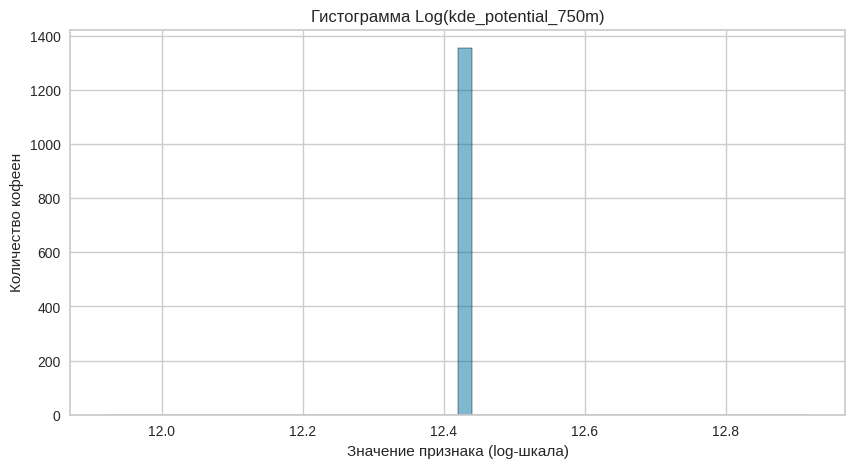


--- Анализ корреляции kde_potential с другими показателями ---


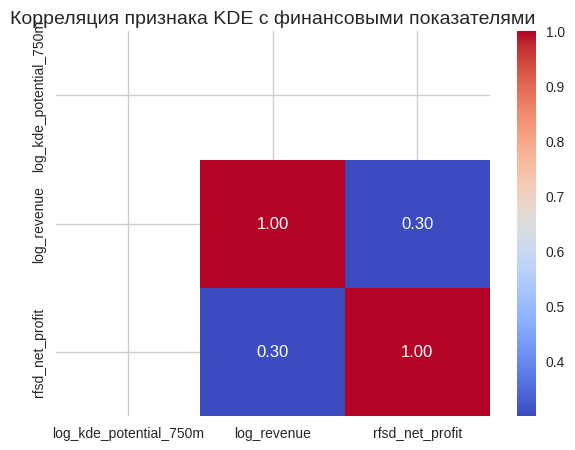

In [ ]:
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# --- Шаг 1: Загрузка данных с уже посчитанными признаками ---
print("--- Загрузка данных с признаками ---")
try:
    df = gpd.read_parquet('data/cafes_with_buffer_features.parquet')
    print(f"✅ Успешно загружено {len(df)} записей.")
except FileNotFoundError:
    print("❗️ Файл 'cafes_with_buffer_features.parquet' не найден.")
    raise

# --- Шаг 2: Анализ распределения признака kde_potential ---
# Возьмем признак для 750м как основной для анализа
feature_to_analyze = 'kde_potential_750m'

print(f"\n--- Анализ распределения '{feature_to_analyze}' ---")
# Удаляем нулевые значения, так как они возникли из-за ошибок и не несут информации
feature_data = df[df[feature_to_analyze] > 0][feature_to_analyze]

print("Описательная статистика:")
print(feature_data.describe())

# Строим гистограмму. Так как значения очень малы, логарифмируем их.
# log1p(x) = log(1+x), это стандартный способ избежать log(0)
plt.figure(figsize=(10, 5))
sns.histplot(np.log1p(feature_data), bins=50, kde=True)
plt.title(f'Гистограмма Log({feature_to_analyze})')
plt.xlabel('Значение признака (log-шкала)')
plt.ylabel('Количество кофеен')
plt.show()

# --- Шаг 3: Корреляционный анализ ---
print("\n--- Анализ корреляции kde_potential с другими показателями ---")

# Обогатим наш датасет данными из RFSD, чтобы посчитать корреляцию
# Это быстрый join, так как мы используем уже сопоставленные данные
try:
    training_data = gpd.read_parquet('data/final_training_dataset.parquet')
    # Выбираем только нужные колонки для объединения
    targets_to_join = training_data[['rfsd_revenue', 'rfsd_net_profit']]
    # Объединяем по индексу
    df_with_targets = df.join(targets_to_join)

    # Оставляем только те строки, где есть все данные для анализа
    corr_df = df_with_targets[[feature_to_analyze, 'rfsd_revenue', 'rfsd_net_profit', 'rating', 'reviews_count']].copy()
    corr_df.dropna(inplace=True)

    # Логарифмируем для корректности
    corr_df['log_revenue'] = np.log1p(corr_df['rfsd_revenue'])
    corr_df[f'log_{feature_to_analyze}'] = np.log1p(corr_df[feature_to_analyze])

    # Считаем и рисуем матрицу
    correlation_matrix = corr_df[[f'log_{feature_to_analyze}', 'log_revenue', 'rfsd_net_profit']].corr()

    plt.figure(figsize=(7, 5))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f'Корреляция признака KDE с финансовыми показателями', fontsize=14)
    plt.show()

except FileNotFoundError:
    print("Файл 'final_training_dataset.parquet' не найден. Корреляционный анализ невозможен.")


In [ ]:
import pandas as pd
import geopandas as gpd
import osmnx as ox
from scipy.spatial import cKDTree
import numpy as np

# --- Шаг 1: Загрузка данных ---
print("--- Шаг 1: Загрузка данных ---")

# Загружаем наш датасет с уже посчитанными признаками
try:
    cafes_with_features = gpd.read_parquet('data/cafes_with_buffer_features.parquet')
    # Убедимся, что это GeoDataFrame с правильной CRS
    if not isinstance(cafes_with_features, gpd.GeoDataFrame):
        cafes_with_features = gpd.GeoDataFrame(
            cafes_with_features,
            geometry=gpd.points_from_xy(cafes_with_features.lon, cafes_with_features.lat),
            crs="EPSG:4326"
        )
    print(f"✅ Загружено {len(cafes_with_features)} кофеен с признаками.")
except FileNotFoundError:
    print("❗️ Файл 'cafes_with_buffer_features.parquet' не найден!")
    raise

# Загружаем POI из OSM
print("\nЗагрузка Точек Интереса (POI) из OSM (может занять время)...")
tags = {
    "railway": ["station", "subway_entrance"], # Станции метро и входы
    "building": ["office", "commercial"],    # Офисные и коммерческие здания (прокси для БЦ)
    "leisure": "park",                       # Парки
    "shop": "mall"                           # Торговые центры
}
pois = ox.features_from_place("Moscow, Russia", tags)
print(f"✅ Загружено {len(pois)} POI.")


# --- Шаг 2: Подготовка данных для расчета ---
print("\n--- Шаг 2: Подготовка данных ---")

# Перепроецируем все в метрическую систему координат (например, UTM для Москвы) для точного расчета расстояний
# Сначала определим UTM зону для центра Москвы
utm_crs = cafes_with_features.estimate_utm_crs()
print(f"Используем проекцию: {utm_crs.name}")

cafes_proj = cafes_with_features.to_crs(utm_crs)
pois_proj = pois.to_crs(utm_crs)

# Разделяем POI на категории
poi_layers = {
    'metro': pois_proj[(pois_proj['railway'].isin(['station', 'subway_entrance'])) & (pois_proj.geometry.geom_type == 'Point')],
    'business_center': pois_proj[(pois_proj['building'].isin(['office', 'commercial']))],
    'park': pois_proj[(pois_proj['leisure'] == 'park')],
    'mall': pois_proj[(pois_proj['shop'] == 'mall')]
}

# Для полигональных POI (парки, ТЦ, БЦ) будем считать расстояние до их границы
for layer in ['business_center', 'park', 'mall']:
    # Преобразуем все геометрии в единый объект для быстрого поиска
    poi_layers[layer]['unary_union'] = poi_layers[layer].unary_union


# --- Шаг 3: Расчет расстояний ---
print("\n--- Шаг 3: Расчет признаков POI (расстояние + количество) ---")

# Задаем радиусы для подсчета количества
radiuses_for_count = [500, 1000] # 500м и 1км

# --- 3.1 Метро (точечный объект) ---
metro_stations = poi_layers['metro']
if not metro_stations.empty:
    # Расстояние до ближайшего
    tree_metro = cKDTree(np.array(list(metro_stations.geometry.apply(lambda p: (p.x, p.y)))))
    distances, _ = tree_metro.query(np.array(list(cafes_proj.geometry.apply(lambda p: (p.x, p.y)))), k=1)
    cafes_proj['dist_to_metro'] = distances.round(0)

    # Количество в радиусе
    # .query_ball_point находит всех соседей в заданном радиусе
    for r in radiuses_for_count:
        neighbors = tree_metro.query_ball_point(np.array(list(cafes_proj.geometry.apply(lambda p: (p.x, p.y)))), r=r)
        # Считаем количество соседей для каждой кофейни
        cafes_proj[f'metro_in_{r}m'] = [len(n) for n in neighbors]
    print("✅ Признаки для метро рассчитаны.")
else:
    print("⚠️ POI для 'metro' не найдены.")

# --- 3.2 Полигональные объекты (парки, ТЦ, БЦ) ---
for layer, name in [('park', 'парка'), ('mall', 'ТЦ'), ('business_center', 'БЦ')]:
    poi_layer_df = poi_layers[layer]
    if not poi_layer_df.empty:
        # Расстояние до ближайшего
        union_geom = poi_layer_df['unary_union'].iloc[0]
        cafes_proj[f'dist_to_{layer}'] = cafes_proj.geometry.distance(union_geom).round(0)

        # Количество в радиусе
        # Здесь используем пространственный join, он эффективнее для полигонов
        for r in radiuses_for_count:
            # Создаем буферы вокруг кофеен
            buffers = cafes_proj.geometry.buffer(r)
            # Присоединяем POI, которые пересекаются с буферами
            join_df = gpd.sjoin(gpd.GeoDataFrame(geometry=buffers), poi_layer_df, how='left', predicate='intersects')
            # Группируем по индексу кофейни и считаем количество пересечений
            count_series = join_df.groupby(join_df.index).size()
            cafes_proj[f'{layer}_in_{r}m'] = count_series
            # Заполняем нулями там, где не нашлось пересечений
            cafes_proj[f'{layer}_in_{r}m'].fillna(0, inplace=True)

        print(f"✅ Признаки для '{name}' рассчитаны.")
    else:
        print(f"⚠️ POI для '{layer}' не найдены.")


# --- Шаг 4: Формирование и сохранение (добавляем все новые колонки) ---
print("\n--- Шаг 4: Формирование итогового датасета ---")

# Собираем имена всех новых колонок
new_feature_cols = [col for col in cafes_proj.columns if 'dist_to_' in col or '_in_' in col]
poi_features = cafes_proj[new_feature_cols]

# Присоединяем их к нашему основному датафрейму
final_df = cafes_with_features.join(poi_features)

print("Пример данных с финальным набором признаков:")
print(final_df[['name', 'dist_to_metro', 'metro_in_500m', 'dist_to_park', 'park_in_500m']].head())

# Сохраняем результат
output_filename = 'data/cafes_with_all_features.parquet'
final_df.to_parquet(output_filename)
print(f"\n✅ Финальный датасет со всеми признаками сохранен в: {output_filename}")

--- Шаг 1: Загрузка данных ---
✅ Загружено 1354 кофеен с признаками.

Загрузка Точек Интереса (POI) из OSM (может занять время)...
✅ Загружено 11659 POI.

--- Шаг 2: Подготовка данных ---
Используем проекцию: WGS 84 / UTM zone 37N

--- Шаг 3: Расчет признаков POI (расстояние + количество) ---
✅ Признаки для метро рассчитаны.
✅ Признаки для 'парка' рассчитаны.
✅ Признаки для 'ТЦ' рассчитаны.
✅ Признаки для 'БЦ' рассчитаны.

--- Шаг 4: Формирование итогового датасета ---
Пример данных с финальным набором признаков:
          name  dist_to_metro  metro_in_500m  dist_to_park  park_in_500m
0     Школьник          371.0              5         131.0             4
1  Coffeemolka          332.0              9         211.0             2
2  Шоколадница        10669.0              0        8344.0             1
3    Кофе Хауз          118.0             28         169.0             4
4  Шоколадница          178.0              6         245.0             1

✅ Финальный датасет со всеми признаками со

In [ ]:
!pip install pycaret

In [ ]:
import os

--- Шаг 1: Загрузка и подготовка данных ---
✅ Подготовлен датасет для AutoML: 513 записей и 19 признаков.

--- Шаг 2: Настройка окружения PyCaret ---
✅ Окружение PyCaret успешно настроено.

--- Шаг 3: Поиск лучшей модели ---


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,7.1490,1114.7312,26.5420,-0.0712,1.1705,0.9817,0.0650
et,Extra Trees Regressor,6.9724,742.9095,22.3266,-0.1756,0.4788,3.0363,0.1320
lasso,Lasso Regression,9.5103,901.0178,24.1055,-0.1777,1.4281,2.3696,0.0960
llar,Lasso Least Angle Regression,9.5262,901.9331,24.1171,-0.1792,1.4289,2.3749,0.0710
en,Elastic Net,11.0121,1000.7374,25.4093,-0.2695,1.8144,1.2080,0.0510
ridge,Ridge Regression,9.9158,909.1231,24.5769,-0.3639,1.4524,2.6861,0.0670
lr,Linear Regression,9.9333,909.4690,24.6118,-0.3785,1.4500,2.7169,2.1100
lar,Least Angle Regression,10.6805,914.2208,24.7073,-0.4326,1.5353,2.9524,0.0550
dummy,Dummy Regressor,12.2165,1075.1865,26.7486,-0.4466,2.0218,0.7042,0.0240
omp,Orthogonal Matching Pursuit,12.2631,1076.2660,26.8300,-0.4983,2.0269,0.7235,0.0330


Processing:   0%|          | 0/81 [00:00<?, ?it/s]


--- Шаг 4: Анализ лучшей модели ---
Лучшая найденная модель:
HuberRegressor()


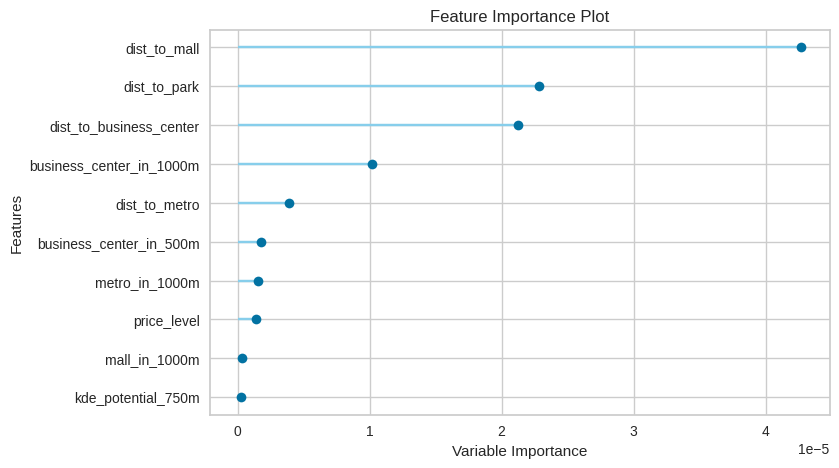

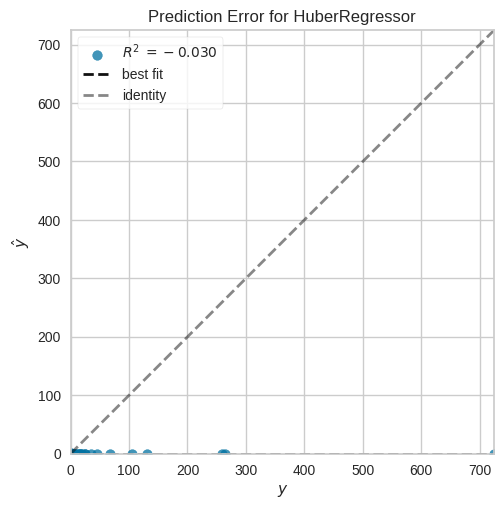


--- Шаг 5: Финализация и сохранение ---
Transformation Pipeline and Model Successfully Saved

✅ Финальная модель и пайплайн сохранены в файлы 'models/automl_proxy_model.pkl'


In [ ]:
import pandas as pd
from pycaret.regression import *

# --- Шаг 1: Загрузка и подготовка финального датасета ---
print("--- Шаг 1: Загрузка и подготовка данных ---")

# Загружаем наш датасет со всеми признаками
df = pd.read_parquet('data/cafes_with_all_features.parquet')

# --- Создаем целевую переменную (y) ---
# (этот блок кода мы уже использовали)
def parse_price_category(value):
    if isinstance(value, str) and '/' in value:
        try: return int(value.split('/')[0])
        except: return None
    return None
df['price_level'] = df['price_category'].apply(parse_price_category)
df['reviews_count'] = pd.to_numeric(df['reviews_count'], errors='coerce')
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')

df['is_not_cheap'] = (df['price_level'] > 1).astype(int)
df['super_feature'] = df['reviews_count'] * df['rating'] * df['is_not_cheap']

# --- Выбираем данные для обучения ---
# Нам нужны только строки из Zoon и где есть все данные
feature_cols = [col for col in df.columns if 'kde_potential' in col or 'competitors' in col or 'dist_to' in col or '_in_' in col]
feature_cols.append('price_level')
target_col = 'super_feature'

# Создаем финальный датафрейм для PyCaret
automl_df = df[feature_cols + [target_col]].copy()
automl_df.dropna(inplace=True)

print(f"✅ Подготовлен датасет для AutoML: {len(automl_df)} записей и {len(feature_cols)} признаков.")


# --- Шаг 2: Настройка окружения PyCaret ---
print("\n--- Шаг 2: Настройка окружения PyCaret ---")

# s = setup(...) - это главная функция. Она анализирует данные,
# готовит их (заполняет пропуски, кодирует категории и т.д.) и
# настраивает пайплайн для эксперимента.
# Мы указываем наш датафрейм, имя целевой переменной и используем 'session_id' для воспроизводимости.
s = setup(data=automl_df, target=target_col, session_id=123, verbose=False) # verbose=False чтобы не было много текста
print("✅ Окружение PyCaret успешно настроено.")


# --- Шаг 3: Поиск и сравнение лучших моделей ---
print("\n--- Шаг 3: Поиск лучшей модели ---")

# compare_models() - волшебная функция. Она обучит и оценит
# все доступные в библиотеке регрессионные модели и выдаст
# отсортированную таблицу с результатами.
# Мы сортируем по R2 (коэффициент детерминации, чем ближе к 1, тем лучше)
best_model = compare_models(sort='R2')


# --- Шаг 4: Анализ лучшей модели ---
print("\n--- Шаг 4: Анализ лучшей модели ---")
print("Лучшая найденная модель:")
print(best_model)

# PyCaret предлагает множество удобных графиков для анализа
# Важность признаков (какие признаки больше всего влияют на результат)
plot_model(best_model, plot='feature')

# График ошибок (показывает, где модель ошибается)
plot_model(best_model, plot='error')


# --- Шаг 5: Финализация и сохранение модели ---
print("\n--- Шаг 5: Финализация и сохранение ---")
# Финализация - это переобучение лучшей модели на ВСЕХ данных
final_model = finalize_model(best_model)

# Сохраняем модель и весь пайплайн предобработки
os.makedirs('models', exist_ok=True)
save_model(final_model, 'models/automl_proxy_model')
print("\n✅ Финальная модель и пайплайн сохранены в файлы 'models/automl_proxy_model.pkl'")

In [ ]:
import pandas as pd
import numpy as np
from pycaret.regression import *

# --- Шаг 1: Подготовка 'золотого' датасета для AutoML ---
print("--- Шаг 1: Подготовка 'золотого' датасета для AutoML ---")

# Загружаем наш финальный датасет со всеми признаками
try:
    df_features = pd.read_parquet('data/cafes_with_all_features.parquet')
except FileNotFoundError:
    print("❗️ Файл 'cafes_with_all_features.parquet' не найден!")
    raise

# Загружаем "золотой" датасет с целевыми переменными
try:
    df_golden = pd.read_parquet('data/final_training_dataset.parquet')
except FileNotFoundError:
    print("❗️ Файл 'final_training_dataset.parquet' не найден!")
    raise

# --- ИСПРАВЛЕНИЕ: Создаем колонку 'price_level' в df_features ---
def parse_price_category(value):
    if isinstance(value, str) and '/' in value:
        try: return int(value.split('/')[0])
        except: return np.nan
    return np.nan
# Применяем к df_features, так как price_category есть там
df_features['price_level'] = df_features['price_category'].apply(parse_price_category)
# Заполняем пропуски медианой, как и раньше
median_price_level = df_features['price_level'].median()
df_features['price_level'].fillna(median_price_level, inplace=True)
print("✅ Колонка 'price_level' создана и добавлена к признакам.")
# --- КОНЕЦ ИСПРАВЛЕНИЯ ---


# Объединяем их, чтобы получить признаки для "золотых" точек
# Мы будем мэржить по индексу, который должен быть уникальным
# Убедимся, что у df_features есть такой же индекс, как у df_golden
df_features_to_join = df_features.loc[df_golden.index]
automl_golden_df = df_golden.join(df_features_to_join.drop(columns=['geometry', 'lat', 'lon'], errors='ignore'), lsuffix='_golden')


# Выбираем признаки и цель
feature_cols = [col for col in automl_golden_df.columns if 'kde_potential' in col or 'competitors' in col or 'dist_to' in col or '_in_' in col]
# Теперь 'price_level' точно есть в датафрейме
feature_cols.append('price_level')
target_col = 'rfsd_revenue'

final_df_for_automl = automl_golden_df[feature_cols + [target_col]].copy()
final_df_for_automl.dropna(inplace=True)

# Логарифмируем выручку
final_df_for_automl[target_col] = np.log1p(final_df_for_automl[target_col])

print(f"Подготовлен 'золотой' датасет для AutoML: {len(final_df_for_automl)} записей.")

# --- Шаг 2 и 3: Запускаем AutoML ---
if len(final_df_for_automl) > 10: # Минимальная проверка, что есть на чем учиться
    print("\n--- Запускаем AutoML для предсказания ВЫРУЧКИ ---")
    s_revenue = setup(data=final_df_for_automl, target=target_col, session_id=456, verbose=False, html=False)
    best_model_revenue = compare_models(sort='R2')

    # --- Шаг 4: Анализ ---
    print("\n--- Лучшая модель для предсказания выручки ---")
    print(best_model_revenue)
    plot_model(best_model_revenue, plot='feature')
else:
    print("\n❗️ Недостаточно данных для запуска AutoML.")


--- Шаг 1: Подготовка 'золотого' датасета для AutoML ---
✅ Колонка 'price_level' создана и добавлена к признакам.
Подготовлен 'золотой' датасет для AutoML: 200 записей.

--- Запускаем AutoML для предсказания ВЫРУЧКИ ---


                                    Model     MAE     MSE    RMSE      R2  \
dummy                     Dummy Regressor  1.6577  4.3752  2.0256 -0.1066   
omp           Orthogonal Matching Pursuit  1.6911  4.6094  2.0696 -0.1489   
br                         Bayesian Ridge  1.6933  4.5113  2.0653 -0.1947   
ridge                    Ridge Regression  1.6774  4.4818  2.0691 -0.2503   
lr                      Linear Regression  1.6807  4.4788  2.0689 -0.2525   
rf                Random Forest Regressor  1.6978  4.7797  2.1311 -0.2849   
lar                Least Angle Regression  1.7046  4.6043  2.1014 -0.3022   
en                            Elastic Net  1.7115  4.7144  2.1188 -0.3487   
llar         Lasso Least Angle Regression  1.7041  4.6701  2.1122 -0.3588   
lasso                    Lasso Regression  1.7041  4.6713  2.1126 -0.3607   
ada                    AdaBoost Regressor  1.7120  4.8828  2.1584 -0.4068   
et                  Extra Trees Regressor  1.7801  5.0382  2.1995 -0.4189   

TypeError: Feature Importance and RFE plots not available for estimators that doesnt support coef_ or feature_importances_ attribute.

In [ ]:
import pandas as pd
import geopandas as gpd
import osmnx as ox
import rasterio
from rasterio.mask import mask
import numpy as np
from scipy.spatial import cKDTree
from tqdm.auto import tqdm
import os

# ==============================================================================
# --- Шаг 1: Загрузка всех необходимых данных ---
# ==============================================================================
print("--- Шаг 1: Загрузка данных ---")

# 1. Полный список кофеен
try:
    all_cafes = gpd.read_parquet('data/all_cafes_cleaned.parquet')
    if not isinstance(all_cafes, gpd.GeoDataFrame):
        all_cafes = gpd.GeoDataFrame(all_cafes, geometry=gpd.points_from_xy(all_cafes.lon, all_cafes.lat), crs="EPSG:4326")
    print(f"✅ Загружено {len(all_cafes)} кофеен.")
except FileNotFoundError:
    print("❗️ Файл 'all_cafes_cleaned_full.parquet' не найден!")
    raise

# 2. KDE-поверхность
kde_raster_path = 'data/kde_surface_FINAL_2.tif' # Используем самый правильный файл
try:
    kde_raster = rasterio.open(kde_raster_path)
    print("✅ Поверхность KDE успешно загружена.")
except rasterio.errors.RasterioIOError:
    print(f"❗️ Файл {kde_raster_path} не найден!")
    raise

# 3. Точки интереса (POI) из OpenStreetMap
print("\nЗагрузка Точек Интереса (POI)...")
tags = {
    "railway": ["station", "subway_entrance"],
    "building": ["office", "commercial"],
    "leisure": "park",
    "shop": "mall"
}
pois = ox.features_from_place("Moscow, Russia", tags)
print(f"✅ Загружено {len(pois)} POI.")


# ==============================================================================
# --- Шаг 2: Подготовка данных (перепроецирование) ---
# ==============================================================================
print("\n--- Шаг 2: Подготовка данных (перепроецирование) ---")

# Определяем подходящую метрическую CRS (UTM для Москвы)
utm_crs = all_cafes.estimate_utm_crs()
print(f"Используем проекцию: {utm_crs.name}")

# Перепроецируем все наши гео-данные в эту систему координат
cafes_proj = all_cafes.to_crs(utm_crs)
pois_proj = pois.to_crs(utm_crs)
print("✅ Кофейни и POI перепроецированы.")

# Разделяем POI на категории для удобства
poi_layers = {
    'metro': pois_proj[(pois_proj['railway'].isin(['station', 'subway_entrance'])) & (pois_proj.geometry.geom_type == 'Point')].copy(),
    'business_center': pois_proj[pois_proj['building'].isin(['office', 'commercial'])].copy(),
    'park': pois_proj[pois_proj['leisure'] == 'park'].copy(),
    'mall': pois_proj[pois_proj['shop'] == 'mall'].copy()
}
# Создаем объединенную геометрию для полигональных слоев для быстрого расчета расстояний
for layer in ['business_center', 'park', 'mall']:
    if not poi_layers[layer].empty:
        poi_layers[layer]['unary_union'] = poi_layers[layer].unary_union
print("✅ Слои POI подготовлены.")


# ==============================================================================
# --- Шаг 3: Расчет признаков в цикле (с несколькими радиусами) ---
# ==============================================================================
print("\n--- Шаг 3: Начало расчета признаков с несколькими радиусами ---")
radiuses_m = [200, 500, 1000]
results = []

for index, cafe in tqdm(cafes_proj.iterrows(), total=len(cafes_proj)):
    cafe_features = {'index': cafe.name}
    buffers = {r: cafe.geometry.buffer(r) for r in radiuses_m}

    # 3.1 Признаки спроса по KDE
    try:
        # Перепроецируем буферы в CRS растра
        buffers_gdf = gpd.GeoDataFrame(geometry=list(buffers.values()), crs=utm_crs)
        buffers_for_kde = buffers_gdf.to_crs(kde_raster.crs)

        for i, r in enumerate(radiuses_m):
            out_image, _ = mask(kde_raster, [buffers_for_kde.iloc[i].geometry], crop=True)
            cafe_features[f'kde_potential_{r}m'] = np.sum(out_image[out_image > 0])

    except Exception:
        for r in radiuses_m: cafe_features[f'kde_potential_{r}m'] = 0

    # 3.2 Признаки конкуренции
    for r in radiuses_m:
        competitors_count = cafes_proj[cafes_proj.within(buffers[r])].shape[0] - 1
        cafe_features[f'competitors_{r}m'] = competitors_count

    # 3.3 Признаки POI
    # Расстояние до ближайшего
    if 'metro' in poi_layers and not poi_layers['metro'].empty:
        tree_metro = cKDTree(np.array(list(poi_layers['metro'].geometry.apply(lambda p: (p.x, p.y)))))
        dist, _ = tree_metro.query([cafe.geometry.x, cafe.geometry.y], k=1)
        cafe_features['dist_to_metro'] = dist

    for layer_name in ['park', 'mall', 'business_center']:
        if layer_name in poi_layers and not poi_layers[layer_name].empty:
            union_geom = poi_layers[layer_name]['unary_union'].iloc[0]
            cafe_features[f'dist_to_{layer_name}'] = cafe.geometry.distance(union_geom)

    # Количество в радиусе
    for r in radiuses_m:
        if 'metro' in poi_layers and not poi_layers['metro'].empty:
            neighbors = tree_metro.query_ball_point([cafe.geometry.x, cafe.geometry.y], r=r)
            cafe_features[f'metro_in_{r}m'] = len(neighbors)

        for layer_name in ['park', 'mall', 'business_center']:
             if layer_name in poi_layers and not poi_layers[layer_name].empty:
                intersecting_pois = poi_layers[layer_name][poi_layers[layer_name].intersects(buffers[r])]
                cafe_features[f'{layer_name}_in_{r}m'] = len(intersecting_pois)

    results.append(cafe_features)

kde_raster.close()


# ==============================================================================
# --- Шаг 4: Формирование и сохранение ---
# ==============================================================================
print("\n--- Шаг 4: Формирование итогового датафрейма ---")
features_df = pd.DataFrame(results).set_index('index')
all_cafes_with_features = all_cafes.join(features_df)

# Добавляем price_level
def parse_price_category(value):
    if isinstance(value, str) and '/' in value:
        try: return int(value.split('/')[0])
        except: return np.nan
    return np.nan
all_cafes_with_features['price_level'] = all_cafes_with_features['price_category'].apply(parse_price_category)
all_cafes_with_features['price_level'].fillna(all_cafes_with_features['price_level'].median(), inplace=True)

# Сохраняем результат
output_filename = 'data/cafes_with_MULTI_RADIUS_features.parquet'
all_cafes_with_features.to_parquet(output_filename)
print(f"\n✅ Финальный датасет со всеми признаками сохранен в: {output_filename}")
print("\nПример новых признаков:")
print(all_cafes_with_features.filter(regex='_500m$|dist_to_').head())

--- Шаг 1: Загрузка данных ---
✅ Загружено 1354 кофеен.
✅ Поверхность KDE успешно загружена.

Загрузка Точек Интереса (POI)...
✅ Загружено 11659 POI.

--- Шаг 2: Подготовка данных (перепроецирование) ---
Используем проекцию: WGS 84 / UTM zone 37N
✅ Кофейни и POI перепроецированы.
✅ Слои POI подготовлены.

--- Шаг 3: Начало расчета признаков с несколькими радиусами ---


  0%|          | 0/1354 [00:00<?, ?it/s]


--- Шаг 4: Формирование итогового датафрейма ---

✅ Финальный датасет со всеми признаками сохранен в: data/cafes_with_MULTI_RADIUS_features.parquet

Пример новых признаков:
   kde_potential_500m  competitors_500m  dist_to_metro  dist_to_park  \
0        6.236909e-18                17     370.644173    130.885428   
1        8.661937e-07                 2     331.949584    210.632077   
2        4.583331e-24                 2   10668.798584   8344.183516   
3        4.487309e-17                11     118.077830    168.598115   
4        8.148996e-28                 1     177.771026    244.945981   

   dist_to_mall  dist_to_business_center  metro_in_500m  park_in_500m  \
0    399.379417                68.227332              5             4   
1     47.994993               228.769435              9             2   
2  10081.951673              3217.730388              0             0   
3    287.505637                 0.000000             28             4   
4      0.000000             

In [ ]:
!pip install mlflow

--- Шаг 1: Загрузка датасета с новыми признаками ---
✅ Загружено 1354 записей с 34 колонками.
✅ Подготовлен датасет для AutoML: 655 записей и 22 признаков.

--- Запускаем AutoML для предсказания 'super_feature' ---


                                    Model      MAE        MSE     RMSE  \
huber                     Huber Regressor   5.2484   744.9807  23.0288   
br                         Bayesian Ridge   9.2088   721.3716  22.9434   
omp           Orthogonal Matching Pursuit   9.2680   722.5676  22.9687   
lasso                    Lasso Regression  10.0358   756.6770  24.0967   
en                            Elastic Net  10.1466   758.8040  24.1787   
ridge                    Ridge Regression  10.8146   776.3720  24.7149   
lr                      Linear Regression  10.8242   776.6321  24.7228   
rf                Random Forest Regressor  10.0549   823.0398  25.4610   
knn                 K Neighbors Regressor   9.3261   838.9543  25.9306   
lightgbm  Light Gradient Boosting Machine  12.5220   898.6477  27.2089   
gbr           Gradient Boosting Regressor   9.6804   813.0582  25.6747   
et                  Extra Trees Regressor  11.2175   931.3538  28.0740   
ada                    AdaBoost Regres

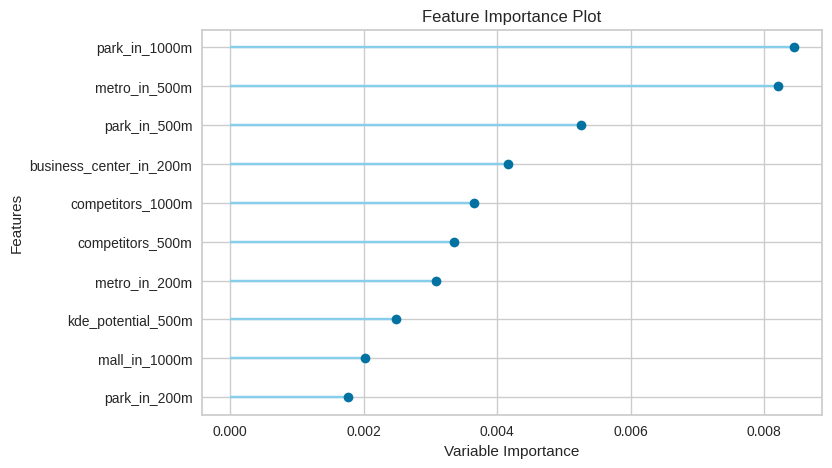

Transformation Pipeline and Model Successfully Saved

✅ Финальная прокси-модель сохранена.


--- Запускаем AutoML для предсказания ВЫРУЧКИ на 'золотом' датасете ---
Подготовлен 'золотой' датасет для AutoML: 200 записей.


                                    Model     MAE      MSE    RMSE       R2  \
br                         Bayesian Ridge  1.6931   4.5090  2.0646  -0.1930   
rf                Random Forest Regressor  1.7441   5.0204  2.1731  -0.3129   
ada                    AdaBoost Regressor  1.7592   4.9255  2.1626  -0.3385   
lasso                    Lasso Regression  1.7044   4.5926  2.0983  -0.3431   
en                            Elastic Net  1.7337   4.7779  2.1350  -0.3593   
omp           Orthogonal Matching Pursuit  1.7110   4.8969  2.1564  -0.4285   
et                  Extra Trees Regressor  1.8356   5.4098  2.2621  -0.4476   
lightgbm  Light Gradient Boosting Machine  1.8430   5.5403  2.2925  -0.5203   
gbr           Gradient Boosting Regressor  1.8835   5.6307  2.3156  -0.5364   
knn                 K Neighbors Regressor  1.8641   5.4267  2.2820  -0.5466   
ridge                    Ridge Regression  1.8287   5.9313  2.3347  -0.5841   
xgboost         Extreme Gradient Boosting  1.8969   

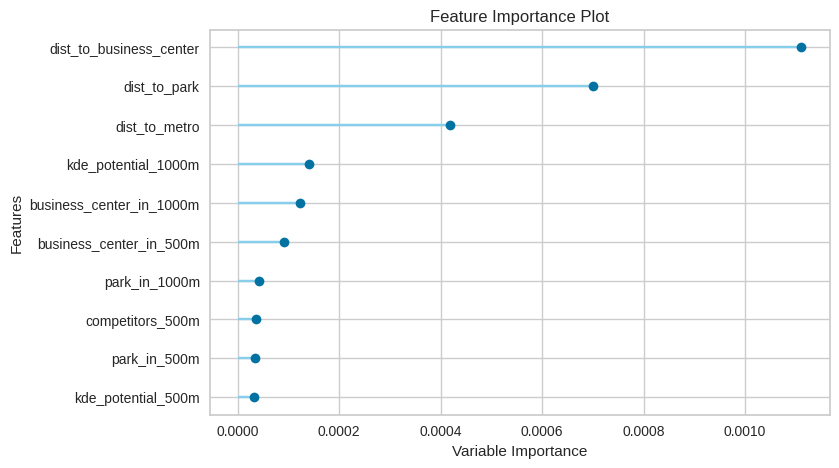

In [ ]:
import pandas as pd
import numpy as np
from pycaret.regression import *
import os

# --- Шаг 1: Загрузка и подготовка финального датасета ---
print("--- Шаг 1: Загрузка датасета с новыми признаками ---")

# Загружаем наш самый полный датасет
try:
    df = pd.read_parquet('data/cafes_with_MULTI_RADIUS_features.parquet')
    print(f"✅ Загружено {len(df)} записей с {len(df.columns)} колонками.")
except FileNotFoundError:
    print("❗️ Файл 'cafes_with_MULTI_RADIUS_features.parquet' не найден!")
    raise

# --- 1.1 Создаем целевую переменную (y) ---
# (этот блок мы уже использовали)
df['reviews_count'] = pd.to_numeric(df['reviews_count'], errors='coerce')
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')

df['is_not_cheap'] = (df['price_level'] > 1).astype(int)
df['super_feature'] = df['reviews_count'] * df['rating'] * df['is_not_cheap']

# --- 1.2 Создаем матрицу признаков (X) ---
# Выбираем все колонки, которые мы сгенерировали
feature_cols = [col for col in df.columns if 'kde_potential' in col or 'competitors' in col or 'dist_to' in col or '_in_' in col]
#feature_cols.append('price_level') # 'price_level' тоже важный признак
target_col = 'super_feature'

# Создаем финальный датафрейм для PyCaret
automl_df = df[feature_cols + [target_col]].copy()
# Удаляем строки, где целевая переменная или признаки отсутствуют
automl_df.dropna(inplace=True)

print(f"✅ Подготовлен датасет для AutoML: {len(automl_df)} записей и {len(feature_cols)} признаков.")


# --- Шаг 2: Настройка и запуск AutoML для прокси-модели ---
if len(automl_df) > 50:
    print("\n--- Запускаем AutoML для предсказания 'super_feature' ---")

    # Настраиваем окружение
    s_proxy = setup(data=automl_df, target=target_col, session_id=123,
                verbose=False, html=False)

    # Ищем лучшую модель
    # Мы можем исключить некоторые очень медленные или простые модели, чтобы ускорить процесс
    best_proxy_model = compare_models(sort='R2', exclude=['lar', 'par', 'dummy', 'llar'])

    # Анализируем лучшую модель
    print("\n--- Лучшая модель для 'super_feature' ---")
    print(best_proxy_model)

    # Важность признаков
    # Этот график теперь будет самым интересным!
    plot_model(best_proxy_model, plot='feature')

    # Финализация и сохранение
    final_proxy_model = finalize_model(best_proxy_model)
    os.makedirs('models', exist_ok=True)
    save_model(final_proxy_model, 'models/automl_proxy_model_v2')
    print("\n✅ Финальная прокси-модель сохранена.")

else:
    print("❗️ Недостаточно данных для запуска AutoML.")


# --- Шаг 3 (Опционально): Запуск AutoML для модели выручки ---
print("\n" + "="*50)
print("\n--- Запускаем AutoML для предсказания ВЫРУЧКИ на 'золотом' датасете ---")

# Загружаем "золотой" датасет с целевыми переменными
try:
    df_golden = pd.read_parquet('data/final_training_dataset.parquet')

    # Присоединяем к нему наши новые, богатые признаки
    # Используем внутренний join, чтобы остались только те, для кого есть все данные
    automl_golden_df = df_golden.join(df.drop(columns=['geometry', 'lat', 'lon']), how='inner', lsuffix='_golden')

    target_col_revenue = 'rfsd_revenue'
    final_df_revenue = automl_golden_df[feature_cols + [target_col_revenue]].copy()
    final_df_revenue.dropna(inplace=True)
    final_df_revenue[target_col_revenue] = np.log1p(final_df_revenue[target_col_revenue]) # Логарифмируем

    print(f"Подготовлен 'золотой' датасет для AutoML: {len(final_df_revenue)} записей.")

    if len(final_df_revenue) > 50:
        s_revenue = setup(data=final_df_revenue, target=target_col_revenue, session_id=456, verbose=False, html=False)
        best_model_revenue = compare_models(sort='R2', exclude=['lar', 'par', 'dummy', 'llar'])
        print("\n--- Лучшая модель для ВЫРУЧКИ (log) ---")
        print(best_model_revenue)
        plot_model(best_model_revenue, plot='feature')
    else:
        print("❗️ Недостаточно данных для обучения модели выручки.")

except FileNotFoundError:
    print("❗️ Файл 'final_training_dataset.parquet' не найден. Пропускаем обучение модели выручки.")


In [ ]:
final_df_revenue

,kde_potential_200m,kde_potential_500m,kde_potential_1000m,competitors_200m,competitors_500m,competitors_1000m,dist_to_metro,dist_to_park,dist_to_mall,dist_to_business_center,...,metro_in_500m,park_in_500m,mall_in_500m,business_center_in_500m,metro_in_1000m,park_in_1000m,mall_in_1000m,business_center_in_1000m,price_level,rfsd_revenue
7,1.101472e-24,1.999589e-23,7.510964e-22,2,19,67,486.878041,160.718328,500.206633,201.425142,...,1,5,0,26,20,19,1,243,1.0,10.652377
12,6.091715e-11,6.199743e-10,6.075736e-09,5,8,16,218.764438,212.414642,212.952936,0.000000,...,2,3,1,42,5,14,2,92,1.0,8.867287
17,9.950505e-09,9.355333e-08,2.857874e-06,0,1,7,86.440755,25.028484,1079.346857,426.529444,...,8,5,0,1,9,6,0,52,1.0,11.313413
25,2.733937e-18,3.106577e-17,4.522450e-16,2,10,40,599.060289,179.155634,265.258057,84.783501,...,0,9,1,46,11,22,3,272,1.0,9.718121
27,1.629402e-23,2.169650e-22,8.488292e-21,2,9,22,471.583313,448.765094,488.335905,43.927732,...,1,1,1,73,8,5,2,185,1.0,11.780706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1302,5.230781e-19,5.667084e-18,1.307275e-16,3,20,47,592.985309,29.779659,601.965330,14.742905,...,0,6,0,68,18,23,1,351,1.0,8.337827
1314,5.893170e-22,1.058685e-20,9.385698e-19,0,0,7,872.156077,679.729290,1297.977697,58.685206,...,0,0,0,43,8,6,0,118,1.0,7.798113
1322,2.560061e-11,1.659858e-10,2.415819e-09,1,8,23,452.801189,306.452069,35.362741,35.362741,...,1,5,2,41,12,14,2,101,1.0,6.470800
1325,1.214537e-18,1.293890e-17,2.811140e-16,8,28,59,728.119931,86.316685,739.898868,23.379221,...,0,8,0,95,22,27,1,436,1.0,8.182559
